In [1]:

# yeni hali 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  LSTM , BatchNormalization

from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, RepeatVector, Concatenate, Attention

from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler


2024-02-06 04:07:59.405208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import yfinance as yf

In [3]:
import os

if os.path.exists('datas'):
    #sil
    os.system('rm -rf datas')

In [4]:
#period = '3000d'
period = 'max'


#features = ['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']
features = [ 'Close' ]  # Sadece kapanış fiyatını kullanın

#tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'NVDA', 'PYPL', 'ADBE','BTC-USD', 'ETH-USD', 'XRP-USD', 'LTC-USD','BCH-USD', 'BNB-USD', 'LINK-USD', 'ADA-USD', 'XLM-USD', 'SOL-USD', 'TRX-USD']

#tickers = ['SOL-USD']

#tickers = ['BTC-USD']

#tickers = ['BTC-USD' , 'SOL-USD'] # ilki yanlış ikinciyi doğru tahmin etti

tickers = [  'SOL-USD', 'BTC-USD' , 'ETH-USD']









In [5]:
def indir_ve_df_olustur(tickers, period):
    # Her bir hisse senedi için boş bir sözlük oluşturun
    pariteler = {}

    # Her bir hisse senedi için döngü oluşturun ve verileri indirin
    for ticker in tickers:
        try:
            # Hisse senedi verilerini indirin
            veri = yf.download(ticker, period=period)

            veri = veri[features]   
            # Veriyi sözlüğe ekleyin
            pariteler[ticker] = veri
            
            
        except Exception as e:
            print(f"{ticker} için veri indirilirken bir hata oluştu: {str(e)}")

    # Her bir hisse senedi için ayrı bir veri çerçevesi oluşturun
    df_listesi = [veri for veri in pariteler.values()]

    return df_listesi

In [6]:
#pariteler adında klasör oluştur :

import os 

if not os.path.exists('datas/pariteler'):
    os.makedirs('datas/pariteler')



In [7]:
datasets = indir_ve_df_olustur(tickers, period)

#pariteler içine kaydet 

for i in range(len(datasets)):
    datasets[i].to_csv(f'datas/pariteler/{tickers[i]}.csv')
    print(f'{tickers[i]} verisi csv olarak kaydedildi')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
SOL-USD verisi csv olarak kaydedildi
BTC-USD verisi csv olarak kaydedildi
ETH-USD verisi csv olarak kaydedildi


In [8]:
scaler  = MinMaxScaler()

#her bir veri çerçevesi için scaled dataset oluştur

if not os.path.exists('datas/scaled_datasets'):
    os.makedirs('datas/scaled_datasets')

scaled_datasets = []

for i in range(len(datasets)):
    scaled_datasets.append(scaler.fit_transform(datasets[i]))
    np.save(f'datas/scaled_datasets/{tickers[i]}.npy', scaled_datasets[i])
    print(f'{tickers[i]} verisi scaled edilerek kaydedildi')
    

SOL-USD verisi scaled edilerek kaydedildi
BTC-USD verisi scaled edilerek kaydedildi
ETH-USD verisi scaled edilerek kaydedildi


In [19]:
#scaled datasetleri göster

for i in range(len(scaled_datasets)):
    print(f'{tickers[i]} verisi için scaled dataset')
    print(scaled_datasets[i])

SOL-USD verisi için scaled dataset
[[0.00168633]
 [0.0010121 ]
 [0.00142108]
 ...
 [0.37677063]
 [0.36747169]
 [0.36656831]]
BTC-USD verisi için scaled dataset
[[0.00414359]
 [0.00365546]
 [0.00321557]
 ...
 [0.63533101]
 [0.62926668]
 [0.62846124]]
ETH-USD verisi için scaled dataset
[[0.0500395 ]
 [0.0454642 ]
 [0.04872747]
 ...
 [0.46781586]
 [0.46644266]
 [0.4683165 ]]


In [9]:
# her bir veri çerçevesi için veriyi dizilere bölme

seq_length = 60  # Son 60 günü kullanarak
pred_length = 7  # Önümüzdeki 7 günü tahmin etme

def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data)-seq_length-pred_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

# her bir veri çerçevesi için veriyi dizilere bölme

if not os.path.exists('datas/sequences'):
    os.makedirs('datas/sequences')

X, y = [], []

for i in range(len(scaled_datasets)):
    X_, y_ = create_sequences(scaled_datasets[i], seq_length, pred_length)
    X.append(X_)
    y.append(y_)
    np.save(f'datas/sequences/X_{tickers[i]}.npy', X_)
    np.save(f'datas/sequences/y_{tickers[i]}.npy', y_)
    print(f'{tickers[i]} verisi dizilere bölünerek kaydedildi')
    


SOL-USD verisi dizilere bölünerek kaydedildi
BTC-USD verisi dizilere bölünerek kaydedildi
ETH-USD verisi dizilere bölünerek kaydedildi


In [10]:
# her bir veri çerçevesi için  seq2seq attention modeli oluştur

# Encoder
encoder_inputs = Input(shape=(seq_length, len(features)))
encoder_lstm = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = RepeatVector(pred_length)(encoder_outputs)
decoder_lstm = LSTM(100, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)


# Dikkat Mekanizması
attention_layer = Attention(use_scale=True)
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])


# TimeDistributed Dense
decoder_dense = TimeDistributed(Dense(len(features)))
decoder_outputs = decoder_dense(decoder_concat_input)

def create_model(encoder_inputs, decoder_outputs):
    model = Model(encoder_inputs, decoder_outputs)
    return model
    


In [11]:
# her bir veri çerçevesi için modeli oluştur derle ve kaydet 

if not os.path.exists('datas/models'):
    os.makedirs('datas/models')
    
models = []

for i in range(len(scaled_datasets)):
    # modeli oluştur
    model = create_model(encoder_inputs, decoder_outputs)
    
    # modeli derle
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # modeli listeye ekle
    models.append(model)
    
    # modeli kaydet
    models[i].save(f'datas/models/{tickers[i]}_model.h5')
    
    
    print(f'{tickers[i]} modeli oluşturuldu ve kaydedildi')

SOL-USD modeli oluşturuldu ve kaydedildi
BTC-USD modeli oluşturuldu ve kaydedildi
ETH-USD modeli oluşturuldu ve kaydedildi


/Users/mustafakapici/anaconda3/envs/all/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# her bir veri çerçevesi için kaydedli modeli yükle ve eğit


batch_size = 60
epochs = 20


for i in range(len(scaled_datasets)):
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5', custom_objects={'Attention': Attention})
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X[i], y[i],
              batch_size=batch_size, epochs=epochs, 
              validation_split=0.2, verbose=1)
    

    # ağırlıkları kaydet 
    model.save_weights(f'datas/models/{tickers[i]}_model_weights.h5')
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')

Epoch 1/20


2024-02-06 04:08:11.023346: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


18/18 [==============================] - 7s 104ms/step - loss: 0.0238 - val_loss: 0.0029
Epoch 2/20


2024-02-06 04:08:13.223134: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


18/18 [==============================] - 1s 36ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 3/20
18/18 [==============================] - 1s 37ms/step - loss: 0.0027 - val_loss: 7.9791e-04
Epoch 4/20
18/18 [==============================] - 1s 37ms/step - loss: 0.0023 - val_loss: 6.8577e-04
Epoch 5/20
18/18 [==============================] - 1s 37ms/step - loss: 0.0021 - val_loss: 8.1253e-04
Epoch 6/20
18/18 [==============================] - 1s 37ms/step - loss: 0.0019 - val_loss: 6.2413e-04
Epoch 7/20
18/18 [==============================] - 1s 39ms/step - loss: 0.0019 - val_loss: 6.6275e-04
Epoch 8/20
18/18 [==============================] - 1s 37ms/step - loss: 0.0020 - val_loss: 6.6915e-04
Epoch 9/20
18/18 [==============================] - 1s 36ms/step - loss: 0.0019 - val_loss: 6.0690e-04
Epoch 10/20
18/18 [==============================] - 1s 37ms/step - loss: 0.0018 - val_loss: 6.0015e-04
Epoch 11/20
18/18 [==============================] - 1s 37ms/step - loss: 0.0018 - val_

2024-02-06 04:08:31.529924: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


45/45 [==============================] - ETA: 0s - loss: 0.0096

2024-02-06 04:08:34.629967: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


45/45 [==============================] - 8s 63ms/step - loss: 0.0096 - val_loss: 0.0013
Epoch 2/20
45/45 [==============================] - 2s 36ms/step - loss: 9.9663e-04 - val_loss: 8.7810e-04
Epoch 3/20
45/45 [==============================] - 2s 36ms/step - loss: 9.1544e-04 - val_loss: 0.0019
Epoch 4/20
45/45 [==============================] - 2s 36ms/step - loss: 8.3381e-04 - val_loss: 0.0012
Epoch 5/20
45/45 [==============================] - 2s 40ms/step - loss: 8.1301e-04 - val_loss: 7.8009e-04
Epoch 6/20
45/45 [==============================] - 2s 37ms/step - loss: 7.4935e-04 - val_loss: 7.3005e-04
Epoch 7/20
45/45 [==============================] - 2s 36ms/step - loss: 7.2737e-04 - val_loss: 8.0872e-04
Epoch 8/20
45/45 [==============================] - 2s 37ms/step - loss: 7.5262e-04 - val_loss: 8.7967e-04
Epoch 9/20
45/45 [==============================] - 2s 36ms/step - loss: 7.2176e-04 - val_loss: 0.0012
Epoch 10/20
45/45 [==============================] - 2s 36ms/step - 

2024-02-06 04:09:11.329733: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


29/30 [============================>.] - ETA: 0s - loss: 0.0173

2024-02-06 04:09:13.854260: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


30/30 [==============================] - 7s 74ms/step - loss: 0.0171 - val_loss: 0.0017
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0021 - val_loss: 7.6509e-04
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0018 - val_loss: 6.2824e-04
Epoch 4/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0017 - val_loss: 5.9704e-04
Epoch 5/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0015 - val_loss: 4.2464e-04
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0015 - val_loss: 5.5054e-04
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0015 - val_loss: 5.0290e-04
Epoch 8/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0015 - val_loss: 4.4203e-04
Epoch 9/20
30/30 [==============================] - 1s 38ms/step - loss: 0.0014 - val_loss: 3.9678e-04
Epoch 10/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0014 - val_l

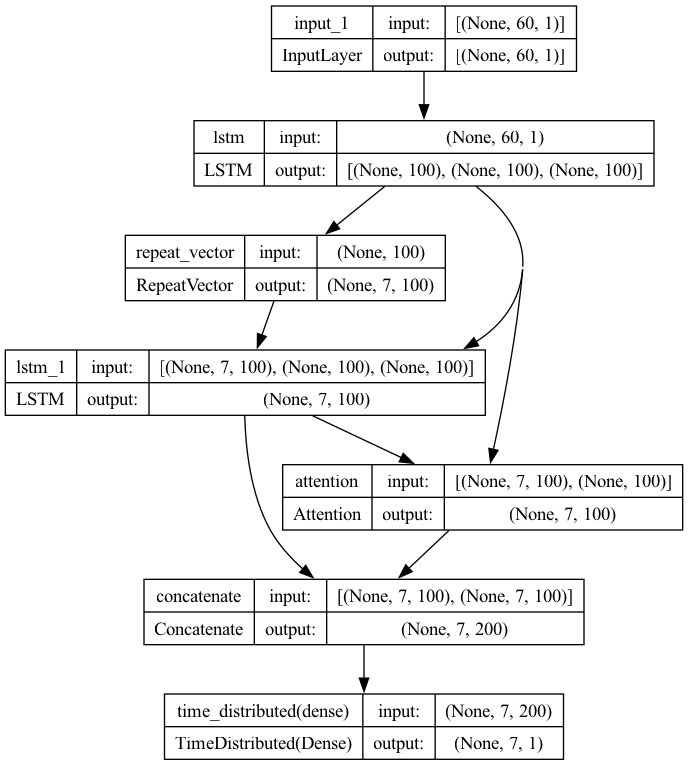

In [13]:
# modelerden bir tanesini png kaydedelim
from tensorflow.keras.utils import plot_model
plot_model(models[0], to_file='datas/model.png', show_shapes=True, show_layer_names=True , rankdir='TB', expand_nested=True, dpi=96, )

In [16]:
# her bir veri çerçevesi için last_sequence = data_scaled[-seq_length:] mantığında prediction yap

if not os.path.exists('datas/predictions'):
    os.makedirs('datas/predictions')
    
predictions = []    

for i in range(len(scaled_datasets)):
    last_sequence = scaled_datasets[i][-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    
    #ağırlıkları yükle
    
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5', custom_objects={'Attention': Attention})
    
    
    model.load_weights(f'datas/models/{tickers[i]}_model_weights.h5')
    
    predicted = model.predict(last_sequence)
    
    predictions.append(predicted)
    np.save(f'datas/predictions/{tickers[i]}_prediction.npy', predicted)
    print(f'{tickers[i]} verisi için prediction yapıldı ve kaydedildi')
    

1/1 [==============================] - 1s 1s/step


2024-02-06 04:11:26.676382: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


SOL-USD verisi için prediction yapıldı ve kaydedildi
1/1 [==============================] - 1s 1s/step


2024-02-06 04:11:28.390449: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


BTC-USD verisi için prediction yapıldı ve kaydedildi
1/1 [==============================] - 1s 1s/step
ETH-USD verisi için prediction yapıldı ve kaydedildi


2024-02-06 04:11:30.110031: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2300 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [17]:
# her bir veri çerçevesi için bütün sütunları predictionları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/forecasts'):
    os.makedirs('datas/forecasts')
    
forecasts = []

for i in range(len(scaled_datasets)):
    prediction = np.load(f'datas/predictions/{tickers[i]}_prediction.npy')
    
    #prediction = predictions[i]
    
    prediction = scaler.inverse_transform(prediction.reshape(-1, len(features) ))
    forecasts.append(prediction)
    np.save(f'datas/forecasts/{tickers[i]}_forecast.npy', prediction)
    print(f'{tickers[i]} verisi için forecast yapıldı ve kaydedildi')
    print(forecasts[i].shape)
    
# dataframe oluştur

for i in range(len(forecasts)):
    
    
    forecast = forecasts[i]
    forecast_dates = datasets[i].index[-pred_length:]
    forecast = pd.DataFrame(forecast, index=forecast_dates, columns=features)
    forecast.to_csv(f'datas/forecasts/{tickers[i]}_forecast.csv')
    print(f'{tickers[i]} verisi için forecast dataframe oluşturuldu ve kaydedildi')


    

SOL-USD verisi için forecast yapıldı ve kaydedildi
(7, 1)
BTC-USD verisi için forecast yapıldı ve kaydedildi
(7, 1)
ETH-USD verisi için forecast yapıldı ve kaydedildi
(7, 1)
SOL-USD verisi için forecast dataframe oluşturuldu ve kaydedildi
BTC-USD verisi için forecast dataframe oluşturuldu ve kaydedildi
ETH-USD verisi için forecast dataframe oluşturuldu ve kaydedildi


In [18]:
#dataframeleri bi yazdır tarihleri ile

for i in range(len(forecasts)):
    forecast = pd.read_csv(f'datas/forecasts/{tickers[i]}_forecast.csv', index_col=0)
    print(f'{tickers[i]} verisi için forecast dataframe')
    print(forecast)

SOL-USD verisi için forecast dataframe
                Close
Date                 
2024-01-30  1791.1140
2024-01-31  1849.2251
2024-02-01  1857.5443
2024-02-02  1850.7506
2024-02-03  1843.9037
2024-02-04  1842.5568
2024-02-06  1847.7781
BTC-USD verisi için forecast dataframe
                Close
Date                 
2024-01-30  3118.9683
2024-01-31  3170.3738
2024-02-01  3168.1150
2024-02-02  3158.6433
2024-02-03  3157.0261
2024-02-04  3165.9846
2024-02-06  3183.8047
ETH-USD verisi için forecast dataframe
                Close
Date                 
2024-01-30  2244.4014
2024-01-31  2294.5054
2024-02-01  2293.2842
2024-02-02  2281.4270
2024-02-03  2273.9736
2024-02-04  2274.9902
2024-02-06  2284.0452


In [ ]:
# Gerçek veriyi yazdır aynı tarihteki 

for i in range(len(datasets)):
    print(f'{tickers[i]} verisi için gerçek veri')
    print(datasets[i].tail(pred_length))


## 2. Kısım

In [ ]:
# her bir veri çerçevesi için eğitime uygun full data hazırla (tensor dataset)

if not os.path.exists('datas/full_data'):
    os.makedirs('datas/full_data')
    
full_data = []

for i in range(len(scaled_datasets)):
    
    scaled_dataset_all = np.load(f'datas/scaled_datasets/{tickers[i]}.npy')
    
    #scaled_dataset_all = scaled_datasets[i].reshape(-1, len(features))
    
    scaled_dataset_all = tf.data.Dataset.from_tensor_slices(scaled_dataset_all)
    
    scaled_dataset_all = tf.data.Dataset.zip((scaled_dataset_all, scaled_dataset_all.skip(seq_length)))
    
    full_data.append(scaled_dataset_all)
    
    full_data[i] = full_data[i].batch(batch_size, drop_remainder=True).prefetch(1)
    
    full_data[i] = full_data[i].cache(f'datas/full_data/{tickers[i]}_full_data')

    print(f'{tickers[i]} verisi için full data hazırlandı')
    
    
    

In [ ]:
# her bir veri çerçevesi için modeli import et ve eğit

for i in range(len(scaled_datasets)):
    model = tf.keras.models.load_model(f'datas/models/{tickers[i]}_model.h5', custom_objects={'Attention': Attention})
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(full_data[i], epochs=epochs, verbose=1)
    
    model.save(f'datas/models/{tickers[i]}_model.h5')
    
    print(f'{tickers[i]} modeli eğitildi ve kaydedildi')
    

In [ ]:
into_future = 1

def future_forecast(model, data, into_future):
    future_forecast = []
    last_sequence = data[-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    for i in range(into_future):
        predicted = model.predict(last_sequence)
        future_forecast.append(predicted)
        last_sequence = np.append(last_sequence, predicted)
        last_sequence = last_sequence[-seq_length:]
        last_sequence = last_sequence.reshape((1, seq_length, len(features)))
    return future_forecast


In [ ]:
print( into_future , seq_length,)

In [ ]:
future_values = []

if not os.path.exists('datas/future_values'):
    os.makedirs('datas/future_values')

for i in range(len(scaled_datasets)):
    future_values.append(future_forecast(models[i], scaled_datasets[i], into_future))
    np.save(f'datas/future_values/{tickers[i]}_future_values.npy', future_values[i])
    print(f'{tickers[i]} verisi için future values yapıldı ve kaydedildi')
    

In [ ]:
# her bir veri çerçevesi için future valuesları geri dönüşüm yap ve yeni bi df e kaydet

if not os.path.exists('datas/future_forecasts'):
    os.makedirs('datas/future_forecasts')
    
future_forecasts = []

for i in range(len(scaled_datasets)):
    
    #np array olarak future values al
    future_value = np.load(f'datas/future_values/{tickers[i]}_future_values.npy')
    future_value = scaler.inverse_transform(future_value.reshape(-1, 1))
    future_forecasts.append(future_value)
    np.save(f'datas/future_forecasts/{tickers[i]}_future_forecast.npy', future_value)
    print(f'{tickers[i]} verisi için future forecast yapıldı ve kaydedildi')
    print(future_forecasts[i].shape)

In [ ]:
print(future_forecasts[0])

In [ ]:
print(into_future) 

In [ ]:

# dataframe oluştur

if not os.path.exists('datas/future_forecasts_df'):
    os.makedirs('datas/future_forecasts_df')

hafta = (into_future*7) + 1

for i in range(len(future_forecasts)):
    future_forecast = future_forecasts[i]
    future_forecast_dates = pd.date_range(start=datasets[i].index[-1], periods=hafta)[1:]
    future_forecast = pd.DataFrame(future_forecast, index=future_forecast_dates, columns=features)
    future_forecast.to_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv')
    print(f'{tickers[i]} verisi için future forecast dataframe oluşturuldu ve kaydedildi')

In [ ]:
# forecast dataframe leri göster


for i in range(len(future_forecasts)):
    future_forecast = pd.read_csv(f'datas/future_forecasts_df/{tickers[i]}_future_forecast.csv', index_col=0)
    print(f'{tickers[i]} verisi için future forecast dataframe')
    print(future_forecast)